<a href="https://colab.research.google.com/github/JordanDCunha/comp215/blob/main/labs/lab04-more_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 4
----------------
#### Name(s): Jordan D'Cunha
#### Date: Jan 20, 2024

By the end of this lab you should be able to:
  * use composition and inheritance in a `class` to categorize related information


During this lab, you will be introduced to the following:
  * something, something



## Near Earth Objects (with more classes)

We'll continue working with Near Earth Object data using NASA's API: https://api.nasa.gov/.  In Lab 3 we defined an Asteroid class that contained a simple data structure.  In this lab, we will be Here's a brief review from Lab 2 on how to use the API.  

In [1]:
# import necessary modules
import datetime, json, requests
from pprint import pprint

### Review: make an API query

Here's a query that gets the record for a single NEO that recently passed by.

In [2]:
#API_KEY = 'DEMO_KEY'  # substitute your API key here
API_KEY = 'QMU73gySBTeUk6FVRje8eMwNOFfI1FZOwRtlf0Xo'

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    #pprint(data)
    print(f'{data["element_count"]} Near Earth Objects found for week of {start_date}')
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

week_start = '2023-01-15'
neos = get_neos(week_start)
assert len(neos) > 0, f'Oh oh!  No NEOs found for {week_start}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
print(f"Record for NEO ID {neos[-1]['id']} is:")
pprint(neo)

117 Near Earth Objects found for week of 2023-01-15
Record for NEO ID 54339874 is:
{'absolute_magnitude_h': 24.86,
 'close_approach_data': [{'close_approach_date': '1949-07-04',
                          'close_approach_date_full': '1949-Jul-04 22:19',
                          'epoch_date_close_approach': -646710060000,
                          'miss_distance': {'astronomical': '0.419726307',
                                            'kilometers': '62790161.51016609',
                                            'lunar': '163.273533423',
                                            'miles': '39015997.166588442'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '73509.6739172087',
                                                'kilometers_per_second': '20.4193538659',
                                                'miles_per_hour': '45676.0526626122'}},
                         {'close_approach_date': '1950-0

## Exercise 1: Define a CloseApproach class

Each NEO record comes with a list of `close_approach_data`, where each record in this list represents a single “close approach” to another orbiting body.
1. Develop a class named `CloseApproach` to represent a single close approach record.  State variables are

        neo (refrence to related NEO object)
        orbiting body (str)
        approach date (datetime object!)
        miss distance (float - choose units, document it, and be consistent!)
        relative velocity (ditto)
  
2. Define a "Factory" class method to construct a `CloseApproach` object from one close approach data record (a dictionary object). This method takes a `neo` object as input for the NEO to which the close approach data belongs. Remember to parse the date/time string into a datetime object.

In [3]:
# Ex. 1 your code here
from dataclasses import dataclass
from datetime import datetime

@dataclass
class CloseApproach:
  '''
  Creates CloseApproach class that takes neo object as input for NEO to which
  close approach data belongs.

  Attributes:
    neo (dict): Informative dictionary for NEO object

    orbiting_body (str): Body the NEO is orbitting around

    approach_date (datetime): The date of close approach to the orbiting body

    miss_distance (float): miss_distance from the orbiting body in a specific unit

    relative_velocity (float):
  '''
  neo: dict
  orbiting_body: str
  approach_date: datetime
  miss_distance: float
  relative_velocity: float

  @classmethod
  def get_closeapproachdata(clss, close_approach_data: dict, neo: str):
    '''
    Creates Asteroid instance from an NEO id

    The class method includes the id, name, estimated diameter, whether the
    asteroid is potentially hazardous, and the list of close_approches into the
    class initalization itself.

    Arguments:
      cls: The Close Approach class itself

      close_approach_data (dict): dictionary with close approach data in it

      neo (dict): Informative dictionary for NEO object
    '''
    assert isinstance(datetime.strptime(close_approach_data['close_approach_date'], '%Y-%m-%d'), datetime)
    return clss(neo,close_approach_data['orbiting_body'],
                datetime.strptime(close_approach_data['close_approach_date'], '%Y-%m-%d'),
                float(close_approach_data['miss_distance']['kilometers']),
                float(close_approach_data['relative_velocity']['kilometers_per_second']))

  def impact_force(self, asteroid_mass: float):
    '''
    Returns impact force for NEO from the mass of the asteroid and its
    velocity

    Arguments:
      asteroid_mass (float): mass of NEO
    '''
    return ((self.relative_velocity/1000) ** 2) * (1/2) * asteroid_mass

testneo = CloseApproach.get_closeapproachdata(neo['close_approach_data'][0], neo)
assert type(testneo.neo) == dict and type(testneo.orbiting_body) == str and type(testneo.miss_distance) == float and type(testneo.relative_velocity) == float
assert testneo.impact_force(50) == 0.01042375030752113
assert testneo.impact_force(0) == 0

## Exercise 2: Add list of CloseApproach objects to the Asteroid

Define an `Asteroid` class, like you did in Lab 3, but give the `Asteroid` list of “close approaches”.  This is called *composition* because each Asteroid object will be *composed* of CloseApproach objects (plus some other things).  There is bit of a catch-22 here because we need the `Asteroid` to construct the `CloseApproach` objects. The first two steps deal with that:

1. Add an instance variable to your Asteroid class with a default value of an empty list:

    ```
    close_approaches:list = []
    ```
      
2. In the Asteroid `from_NEO` factory, use a list comprehension to build the list of `CloseApproach` objects for the Asteroid instance, and then set the instance's `close_approaches` variable before returning it. Setting the value of an object's instance variables from outside the class is generally frowned upon - this is why we make the factory a method of the class itself.

3. Add a method to `Asteroid` to return the `CloseApproach` object for the nearest miss (ie. smallest `missed_distance`):
    ```
    def nearest_miss(self):
        ...
    ```

4. Add a method to the Asteroid class, `closest_earth_approach`, that returns the CloseApproach object that represents the closest approach the Asteroid makes to Earth.
    ```
    def closest_earth_approach(self):
        ...
    ```

Write some test code to demonstrate these new features.

In [4]:
# Ex. 2 your code here
from dataclasses import dataclass, field
import math

@dataclass
class Asteroid:
  '''
  Creates Asteroid class for specific NEO

  This class provides the str and repr representations for a specific NEO asteroid
  with information to the id, name, estimated diameter, whether the NEO is
  potentially hazardous and the list of close_approaches

  Attributes:

    id (str): ID of asteroid object

    name (str): Name of asteroid object

    estimated_diameter (float): Estimated diameter of the Asteroid

    is_potentially_hazardous (bool): Whether or not the NEO is hazardous to the orbiting body

    close_approaches(list): List of close_approaches for asteroid
  '''
  id: str
  name: str
  estimated_diameter: float
  is_potentially_hazardous: bool
  close_approaches: list = field(default_factory=list)

  @classmethod
  def from_NEO(clss, neo_id: str):
    '''
    Creates Asteroid instance from an NEO id

    The class method includes the id, name, estimated diameter, whether the
    asteroid is potentially hazardous, and the list of close_approches into the
    class initalization itself.

    Arguments:
      cls: The Asteroid class itself

      neo_id (str): ID of NEO for asteroid
    '''
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{neo_id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    close_approaches=[CloseApproach.get_closeapproachdata(neo['close_approach_data'][i], neo) for i in range(len(neo['close_approach_data']))]

    return clss(id=data['id'],name=data['name'],
                estimated_diameter=data['estimated_diameter']['kilometers']['estimated_diameter_min'],
                is_potentially_hazardous=data['is_potentially_hazardous_asteroid'],
                close_approaches=close_approaches)

  def nearest_miss(self):
    ''' Returns nearest_miss for asteroid in close approach data'''
    return min(float(close_approach.miss_distance) for close_approach in self.close_approaches)

  def closest_earth_approach(self):
    '''Returns closest earth approach after the '''
    miss_distance = self.nearest_miss()
    miss_list = [float(close_approach.miss_distance) for close_approach in self.close_approaches]
    for i in range(len(miss_list)):
      if miss_distance == miss_list[i]:
        closest_earth_approach = self.close_approaches[i]
    return closest_earth_approach

  def estimated_mass(self):
    '''Returns estimated mass of Asteroid from estimated diameter'''
    return ((4/3) * math.pi * (self.estimated_diameter / 2) ** 3) * 3000

testeroid = Asteroid.from_NEO(neo['id'])

assert type(testeroid.id) == str
assert type(testeroid.name) == str
assert type(testeroid.estimated_diameter) == float
assert type(testeroid.is_potentially_hazardous) == bool
assert type(testeroid.close_approaches) == list
assert testeroid.estimated_mass() == 0.03579190439908469

## Exercise 3: Plot the Closest Approaches

Write a function that takes an Asteroid object as a parameter and makes a timeline plot of close approaches.  You may wish to use the `matplotlib.pyplot` `plot` object.  Here is an example of a timeline plot for the asteroid with neo id '54339874'

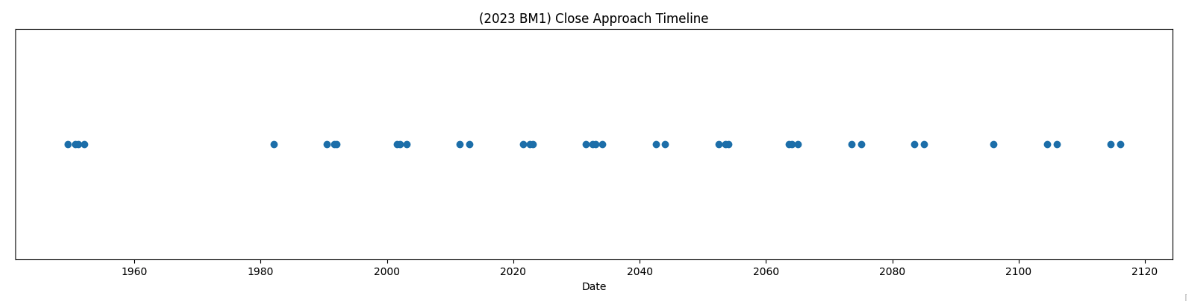

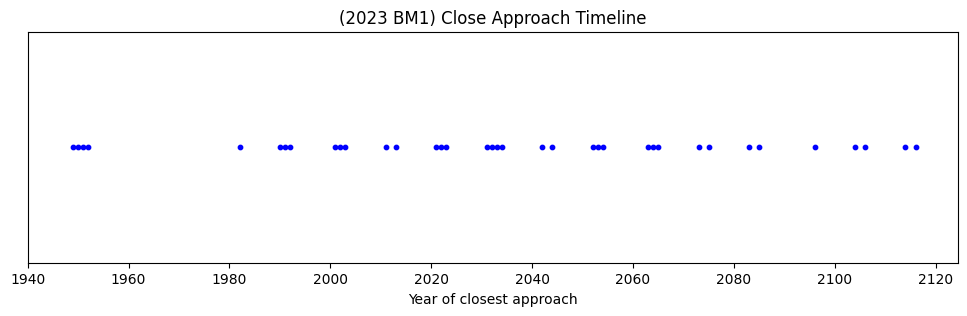

In [5]:
# Ex. 3 your code here
import matplotlib.pyplot as plt

def plot_close_approaches(asteroid):
  closest_asteroid = asteroid.closest_earth_approach()
  year_list = [int(closest_asteroid.neo['close_approach_data'][i]['close_approach_date'][:4]) for i in range(len(closest_asteroid.neo['close_approach_data']))]
  events = [1] * len(year_list)
  plt.figure(figsize=(12, 3))
  plt.scatter(year_list, events, marker='o', color='blue', s=10)
  plt.title(f'{asteroid.name} Close Approach Timeline')
  plt.xlabel('Year of closest approach')
  plt.xticks(range(1940, max(year_list)+20, 20))
  plt.yticks([])
  plt.show()



asteroid = Asteroid.from_NEO(neo['id'])
plot_close_approaches(asteroid)

## Challenge - Take your skills to the next level...

 With these data structures in place, we can now start answering all kinds of interesting questions about a single Asteroid or a set of Asteroids.  
Here’s a couple ideas to try:



* write a **function** named `most_dangerous_approach`, that takes a date range and returns a single “potentially hazardous” Asteroid object that makes the closest approach to Earth in within that range.  Your algorithm will ultimately need to:
    * grab the list of NEO’s for the given date range;
    * use a list comprehension to build the list of Asteroid objects for the NEO’s returned
    * use a list comprehension to filter  potentially hazardous Asteroids only;
    * use a list comprehension to map each Asteroid to its  closest_earth_approach
    * apply Python’s min function to identify the Asteroid with the closest_earth_approach

You may want to decompose some of these steps into smaller functions.
* add a method to the Asteroid class, estimated_mass, that computes an estimate of the Asteroid’s mass based on its diameter.  This is a model – state your assumptions.
* add a method to the CloseApproach class, impact_force,  that estimates the force of impact if the Asteroid hit the orbiting object.  Again, this is a model, state your assumptions.

In [7]:
# Ex. 5 (challenge) your code here
import time
from datetime import date, timedelta

def most_dangerous_approach(date_range):
  '''
  Returns most dangerous approach for an NEO in a specific date range

  Parameters:
    date_range (tuple): date range for neos
  '''
  url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={date_range[0]}&end_date={date_range[1]}&api_key={API_KEY}'
  response = requests.request("GET", url, headers={}, data={})
  data = json.loads(response.text)
  neos = [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records]
  id_list = [neo['id'] for neo in neos]
  asteroid_list = [Asteroid.from_NEO(id) for id in id_list[25:50]]
  hazardous_asteroids = [asteroid for asteroid in asteroid_list if asteroid.is_potentially_hazardous == True]
  if len(hazardous_asteroids) == 0:
    print("No Hazardous Asteroids!")
    return
  closest_hazardous_asteroids = [asteroid.closest_earth_approach() for asteroid in hazardous_asteroids]
  closest_hazardous_asteroid_distances = [asteroid.miss_distance for asteroid in closest_hazardous_asteroids]
  smallest_closest_approach = min(closest_hazardous_asteroid_distances)
  print(smallest_closest_approach)

today = date.today()
weekago = today - timedelta(days=7)
data_range = (weekago, today)
most_dangerous_approach(data_range)

No Hazardous Asteroids!
